# Word2Vec

Let's work on skipgram-based implementation of word2vec.

In [4]:
#import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

### Loading 'webtext' corpus from NLTK

In [5]:
import nltk
from nltk.corpus import webtext

# Download the Web Text corpus
nltk.download('webtext')

[nltk_data] Downloading package webtext to
[nltk_data]     /Users/sbasnyat/nltk_data...
[nltk_data]   Package webtext is already up-to-date!


True

In [6]:
raw_text = webtext.raw()
corpus = raw_text.split('\n')  # Split raw text into sentences based on newlines

In [7]:
print(len(corpus))

29071


In [8]:
print(corpus[1])

When in full screen mode


In [9]:
corpus_tokenized = [[word.lower() for word in sentence.split() if word.isalnum()]for sentence in corpus]


In [10]:
print(corpus_tokenized[:5])

[['cookie', 'allow', 'sites', 'that', 'set', 'removed', 'cookies', 'to', 'set', 'future', 'should', 'stay', 'checked'], ['when', 'in', 'full', 'screen', 'mode'], ['pressing', 'should', 'open', 'a', 'new', 'browser', 'when', 'only', 'download', 'dialog', 'is', 'left', 'open'], ['add', 'icons', 'to', 'context', 'menu'], ['so', 'called', 'should', 'be', 'made', 'a', 'proper', 'toolbar', 'or', 'given', 'the', 'ability', 'collapse']]


In [11]:
print("Sample tokenized sentence:", corpus_tokenized[0])
print("Total tokenized sentences:", len(corpus_tokenized))

Sample tokenized sentence: ['cookie', 'allow', 'sites', 'that', 'set', 'removed', 'cookies', 'to', 'set', 'future', 'should', 'stay', 'checked']
Total tokenized sentences: 29071


In [12]:
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus_tokenized)))

In [13]:
print("Sample vocabulary words:", vocab[:5])
print("Vocabulary size:", len(vocab))

Sample vocabulary words: ['yourself', 'thunderstorm', 'segmentation', 'stimulated', 'undeline']
Vocabulary size: 12888


In [14]:
word2index = {w: i for i, w in enumerate(vocab)}


In [15]:
print(list(word2index.items())[:5])

[('yourself', 0), ('thunderstorm', 1), ('segmentation', 2), ('stimulated', 3), ('undeline', 4)]


In [16]:
#append UNK
vocab.append('<UNK>')

In [17]:
word2index['<UNK>'] = 0

In [18]:
#just in case we need to use
index2word = {v:k for k, v in word2index.items()} 

In [19]:
#vocab size
voc_size = len(vocab)
print(voc_size)

12889


### Preparing train data

In [20]:
print(corpus[:3])

['Cookie Manager: "Don\'t allow sites that set removed cookies to set future cookies" should stay checked\r', 'When in full screen mode\r', 'Pressing Ctrl-N should open a new browser when only download dialog is left open\r']


In [22]:
window_size = 2

#Function to dynamically change window size
def change_window_size(window_size_new):
    window_size = window_size_new

In [23]:
def random_batch(batch_size, corpus ,window_size=2):
    
    skipgrams = []

    # For each sentence in the corpus
    for sent in corpus:
        for i in range(window_size, len(sent) - window_size): 
            center = word2index[sent[i]]
            for j in range(1, window_size + 1):
                context = [word2index[sent[i - j]], word2index[sent[i + j]]]  
                for c in context:
                    skipgrams.append([center, c])
                
    # Randomly select skip-grams for the batch
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
             
    # Appending some list of inputs and labels
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([skipgrams[index][0]])  # Center word
        random_labels.append([skipgrams[index][1]])  # Context word
        
    return np.array(random_inputs), np.array(random_labels)
            

### Testing the method

In [24]:
#testing the method
batch_size = 5 # mini-batch size
input_batch, target_batch = random_batch(batch_size, corpus_tokenized, 4)

print("Input: ", input_batch)
print("Target: ", target_batch)

#we will convert them to tensor during training, so don't worry...

Input:  [[12846]
 [11949]
 [10428]
 [ 1911]
 [  670]]
Target:  [[ 2421]
 [ 7623]
 [12846]
 [11591]
 [ 8346]]


### Word2Vec Model

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

In [25]:
import torch.nn as nn

In [26]:
class Skipgram(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, emb_size)
        self.embedding_u = nn.Embedding(vocab_size, emb_size)
    
    def forward(self, center_words, target_words, all_vocabs):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        all_embeds    = self.embedding_u(all_vocabs) #   [batch_size, voc_size, emb_size]
        
        scores = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]

        norm_scores = all_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, voc_size, emb_size] @ [batch_size, emb_size, 1] = [batch_size, voc_size, 1] = [batch_size, voc_size]

        nll = -torch.mean(torch.log(torch.exp(scores)/torch.sum(torch.exp(norm_scores), 1).unsqueeze(1))) # log-softmax
        # scalar (loss must be scalar)    
            
        return nll # negative log likelihood

### Training

In [27]:
vocab_size = len(vocab)
vocab_size

12889

In [28]:
batch_size = 2
def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocab), word2index).expand(batch_size, vocab_size)
all_vocabs.shape

torch.Size([2, 12889])

In [29]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
import time

# Training
batch_size = 2            # Mini-batch size
embedding_size = 2        # For visualization
num_epochs = 500         # Total epochs
learning_rate = 0.001 

model_Word2Vec = Skipgram(vocab_size, embedding_size)
optimizer = optim.Adam(model_Word2Vec.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    start_time = time.time()
    
    # Generate random batch
    input_batch, target_batch = random_batch(batch_size, corpus_tokenized, window_size=3)
    input_batch = torch.LongTensor(input_batch)  # [batch_size, 1]
    target_batch = torch.LongTensor(target_batch)  # [batch_size, 1]

    optimizer.zero_grad()
    loss = model_Word2Vec(input_batch, target_batch, all_vocabs)
    
    loss.backward()
    optimizer.step()
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")


Epoch: 100 | cost: 9.907738 | time: 0m 0s
Epoch: 200 | cost: 9.505288 | time: 0m 0s
Epoch: 300 | cost: 11.269398 | time: 0m 0s
Epoch: 400 | cost: 9.524817 | time: 0m 0s
Epoch: 500 | cost: 11.614952 | time: 0m 0s


### Embeddings

In [31]:
#list of vocabs
vocab[:10]

['yourself',
 'thunderstorm',
 'segmentation',
 'stimulated',
 'undeline',
 'says',
 'communism',
 'intel',
 'lengthy',
 'mount']

In [32]:
word = vocab[0]

In [33]:
#numericalization
id = word2index[word]
id

0

In [34]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [35]:
#get the embedding by averaging
v_embed_Word2Vec = model_Word2Vec.embedding_v(id_tensor)
u_embed_Word2Vec = model_Word2Vec.embedding_u(id_tensor)

v_embed_Word2Vec, u_embed_Word2Vec

(tensor([[-0.6682, -0.7490]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.7921, -0.8733]], grad_fn=<EmbeddingBackward0>))

In [36]:
#average to get the word embedding
word_embed = (v_embed_Word2Vec + u_embed_Word2Vec) / 2
word_embed[0][1]

tensor(-0.8112, grad_fn=<SelectBackward0>)

In [37]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model_Word2Vec.embedding_v(id_tensor)
    u_embed = model_Word2Vec.embedding_u(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

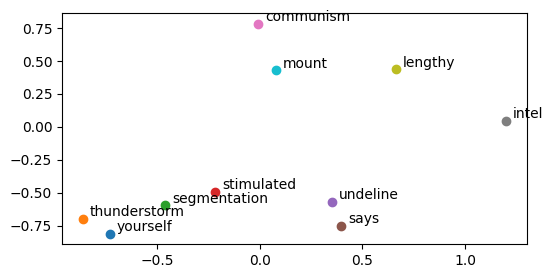

In [38]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:10]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

### Cosine similarity

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

In [39]:
vocab

['yourself',
 'thunderstorm',
 'segmentation',
 'stimulated',
 'undeline',
 'says',
 'communism',
 'intel',
 'lengthy',
 'mount',
 'telekenesis',
 'woant',
 'sips',
 'apostrophe',
 'pantano',
 'native',
 'room',
 'bunnies',
 'sparkly',
 'topic',
 'brother',
 'boop',
 'admitting',
 'noticed',
 'advancing',
 'bash',
 'passito',
 'haut',
 'owe',
 'speaker',
 'lan',
 'eradicate',
 'mta',
 'pouty',
 'workshop',
 'structured',
 'hurt',
 'stocking',
 'skywalker',
 'printed',
 'mike',
 'possible',
 'sexual',
 'sunys',
 'tiff',
 'drink',
 'whites',
 'reminds',
 'dragonball',
 'top',
 'particular',
 'pen',
 'waiting',
 'lasting',
 'vcrs',
 'applied',
 'walt',
 'cautious',
 'grim',
 'winamp',
 'stroke',
 'spacer',
 'roles',
 'acidity',
 'exceptions',
 'emilion',
 'scare',
 'resemble',
 'dildo',
 'vinegar',
 'sister',
 'descend',
 'option',
 'chronological',
 'mothers',
 'sitting',
 'empire',
 'unless',
 'needy',
 'nicer',
 'end',
 'gewurz',
 'notion',
 'reconfigured',
 'electrons',
 'box',
 'repr

In [40]:
#let's try similarity between first and second, and second and third
cat          = get_embed('cat')
fruit        = get_embed('fruit')
animal       = get_embed('animal')

In [41]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim
    
print(f"cat vs. fruit: ",        cos_sim(cat, fruit))
print(f"cat vs. animal: ",       cos_sim(cat, animal))
print(f"cat vs. cat: ",          cos_sim(cat, cat))

cat vs. fruit:  -0.959987300678032
cat vs. animal:  -0.9802514254132302
cat vs. cat:  0.9999999999999999


In [45]:
import scipy

In [46]:
#scipy version
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

print(f"cat vs. fruit: ",        cos_sim(cat, fruit))
print(f"cat vs. animal: ",       cos_sim(cat, animal))
print(f"cat vs. cat: ",          cos_sim(cat, cat))

cat vs. fruit:  -0.959987300678032
cat vs. animal:  -0.9802514254132302
cat vs. cat:  1.0


## Negative Sampling

### Prepare train data and unigram table

In [47]:
import random
import torch

In [48]:
input_batch  = torch.Tensor(input_batch)
target_batch = torch.LongTensor(target_batch)

In [49]:
input_batch.shape, target_batch.shape

(torch.Size([2, 1]), torch.Size([2, 1]))

In [50]:
from collections import Counter
Z = 0.001
word_count = Counter(flatten(corpus_tokenized))
num_total_words = sum([c for w, c in word_count.items()])

In [51]:
num_total_words

224508

In [52]:
unigram_table = []

for vo in vocab:
    unigram_table.extend([vo] * int(((word_count[vo]/num_total_words)**0.75)/Z))

In [53]:
Counter(unigram_table)

Counter({'the': 79,
         'to': 68,
         'i': 66,
         'a': 66,
         'you': 53,
         'and': 52,
         'in': 49,
         'of': 40,
         'on': 40,
         'is': 38,
         'not': 34,
         'for': 27,
         'that': 27,
         'with': 27,
         'when': 26,
         'it': 26,
         'girl': 24,
         'my': 23,
         'this': 21,
         'but': 21,
         'have': 21,
         'be': 20,
         'are': 19,
         'like': 19,
         'was': 19,
         'so': 19,
         'guy': 19,
         'if': 18,
         'just': 17,
         'from': 17,
         'what': 16,
         'do': 16,
         'at': 16,
         'your': 16,
         'all': 15,
         'get': 15,
         'he': 15,
         'me': 14,
         'page': 14,
         'no': 14,
         'firefox': 14,
         'or': 13,
         'does': 13,
         'we': 13,
         'new': 13,
         'can': 12,
         'they': 12,
         'up': 12,
         'as': 12,
         'should': 12,
  

In [54]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.size(0)
    neg_samples = []
    for i in range(batch_size):
        nsample = []
        target_index = targets[i].item()
        while len(nsample) < k: # num of sampling
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).view(1, -1))
    
    return torch.cat(neg_samples)

In [55]:
num_neg = 5
negative_sampling(target_batch, unigram_table, num_neg)

tensor([[ 8346, 10992,  7535,  8380,  4565],
        [ 2421, 12547, 11658, 11726,  1029]])

In [56]:
target_batch[1]

tensor([4944])

### Model

In [57]:
class SkipgramNegSampling(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super(SkipgramNegSampling, self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, emb_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, emb_size) # out embedding
        self.logsigmoid = nn.LogSigmoid()

    
    def forward(self, center_words, target_words, negative_words):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        neg_embeds    = -self.embedding_u(negative_words) # [batch_size, num_neg, emb_size]
        
        positive_score = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        negative_score = neg_embeds.bmm(center_embeds.transpose(1, 2))
        #[batch_size, k, emb_size] @ [batch_size, emb_size, 1] = [batch_size, k, 1]
        
        loss = self.logsigmoid(positive_score) + torch.sum(self.logsigmoid(negative_score), 1)
                
        return -torch.mean(loss)
    

    def prediction(self, inputs):
        embeds = self.embedding_v(inputs)
        
        return embeds

### Training

In [58]:
batch_size     = 2 
embedding_size = 2 
model_Word2Vec_Neg         = SkipgramNegSampling(voc_size, embedding_size)
num_neg        = 10 

optimizer = optim.Adam(model_Word2Vec_Neg.parameters(), lr=0.001)

In [59]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [60]:
import time

# Training
num_epochs = 500
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch = random_batch(batch_size, corpus_tokenized, window_size = 3)
    
    #input_batch: [batch_size, 1]
    input_batch = torch.LongTensor(input_batch)
    
    #target_batch: [batch_size, 1]
    target_batch = torch.LongTensor(target_batch)
    
    #negs_batch:   [batch_size, num_neg]
    negs_batch = negative_sampling(target_batch, unigram_table, num_neg)
    
    optimizer.zero_grad()
        
    loss = model_Word2Vec_Neg(input_batch, target_batch, negs_batch)
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)
    
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")

Epoch: 100 | cost: 5.788262 | time: 0m 0s
Epoch: 200 | cost: 10.235413 | time: 0m 0s
Epoch: 300 | cost: 8.598131 | time: 0m 0s
Epoch: 400 | cost: 7.772629 | time: 0m 0s
Epoch: 500 | cost: 7.405822 | time: 0m 0s


### Embedding

In [61]:
#list of vocabs
vocab[:10]

['yourself',
 'thunderstorm',
 'segmentation',
 'stimulated',
 'undeline',
 'says',
 'communism',
 'intel',
 'lengthy',
 'mount']

In [62]:
word = vocab[0]

In [63]:
#numericalization
id = word2index[word]
id

0

In [64]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [65]:
#get the embedding by averaging
v_embed = model_Word2Vec_Neg.embedding_v(id_tensor)
u_embed = model_Word2Vec_Neg.embedding_u(id_tensor)

v_embed, u_embed

(tensor([[-0.7469, -1.7076]], grad_fn=<EmbeddingBackward0>),
 tensor([[-1.2032, -0.3870]], grad_fn=<EmbeddingBackward0>))

In [66]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(-1.0473, grad_fn=<SelectBackward0>)

In [67]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model_Word2Vec_Neg.embedding_v(id_tensor)
    u_embed = model_Word2Vec_Neg.embedding_u(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

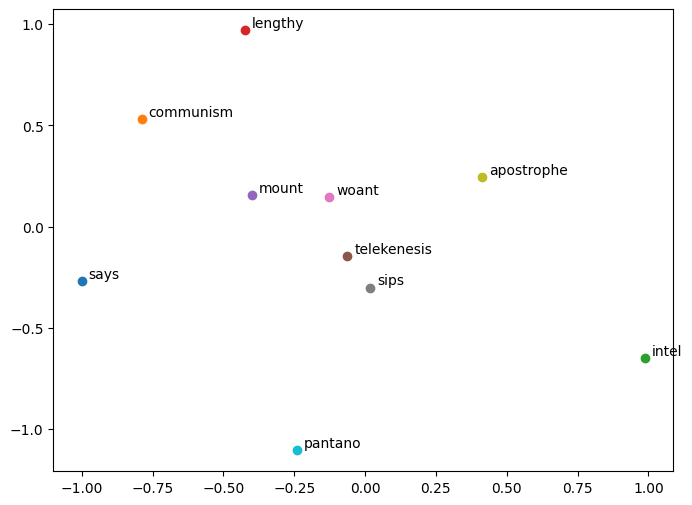

In [68]:
plt.figure(figsize=(8,6))
for i, word in enumerate(vocab[5:15]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## Semantic and Syntatic Accuracy

In [69]:
def cos_sim(a, b):
    return 1 - spatial.distance.cosine(a, b)

In [70]:
def get_embed(word, current_model):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (current_model.embedding_v(word)+ current_model.embedding_u(word))/2
    return np.array(embed[0].detach().numpy())

In [71]:
def find_analogy(a, b, c, model, vocabs):
    emb_a, emb_b, emb_c = get_embed(a, model), get_embed(b, model), get_embed(c, model)
    vector = emb_b - emb_a + emb_c

    similarity = -1
    best_word = None

    for vocab in vocabs:
        if vocab not in [a, b, c]:
            current_sim = cos_sim(vector, get_embed(vocab, model))
            if current_sim > similarity:
                similarity = current_sim
                best_word = vocab

    return best_word

In [72]:
def evaluate_model(model, dataset, vocabs):
    syntactic_correct = 0
    syntactic_total = 0
    semantic_correct = 0
    semantic_total = 0

    for task in dataset:
        a, b, c, expected_d, category = task
        predicted_d = find_analogy(a, b, c, model, vocabs)

        if category == 'syntactic':
            syntactic_total += 1
            if predicted_d == expected_d:
                syntactic_correct += 1

        elif category == 'semantic':
            semantic_total += 1
            if predicted_d == expected_d:
                semantic_correct += 1

    syntactic_accuracy = syntactic_correct / syntactic_total if syntactic_total > 0 else 0
    semantic_accuracy = semantic_correct / semantic_total if semantic_total > 0 else 0

    return syntactic_accuracy, semantic_accuracy

In [73]:
syntactic_tasks = []
semantic_tasks = []
current_category = None

def seperate_category(filepath):
    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith(":"):  # Indicates a category
                if "gram" in line.lower():  # Syntactic category
                    current_category = "syntactic"
                else:  # Semantic category
                        current_category = "semantic"
            elif line:  # Skip empty lines
                a, b, c, d = line.split()
                if current_category == "syntactic":
                    syntactic_tasks.append((a, b, c, d))
                elif current_category == "semantic":
                    semantic_tasks.append((a, b, c, d))
        
    return syntactic_tasks, semantic_tasks

In [75]:
filepath = "word-test.v1.txt"
syntactic_tasks, semantic_tasks = seperate_category(filepath)

In [76]:
print(len(syntactic_tasks))

10675


In [77]:
print(len(semantic_tasks))

8869


In [78]:
dataset = [
    (*task, "syntactic") for task in syntactic_tasks
] + [
    (*task, "semantic") for task in semantic_tasks
]

In [ ]:
models = {"word2vec_neg": model_Word2Vec_Neg, "word2vec": model_Word2Vec}

results = {}

for model_name, model in models.items():
    vocabs = vocab
    syntactic_accuracy, semantic_accuracy = evaluate_model(model, dataset, vocabs)
    results[model_name] = {
        "syntactic_accuracy": syntactic_accuracy,
        "semantic_accuracy": semantic_accuracy
        }